## <span style="color:red">Important: Before running this notebook, make sure the mosfit, corner, matplotlib, and seaborn libraries are installed in your Python environment (install them with conda or pip).</span>

### Load the data from `walkers.json`, the main output file produced by the last MOSFiT run.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import corner
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook
from collections import OrderedDict
from mosfit.plotting import bandcolorf

sns.reset_orig()

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 14})

with open('../products/walkers.json', 'r', encoding = 'utf-8') as f:
    data = json.loads(f.read())
    if 'name' not in data:
        data = data[list(data.keys())[0]]

photo = data['photometry']
model = data['models'][0]
redshift = float(data['redshift'][0]['value'])

real_data = len([x for x in photo if 'band' in x and 'magnitude' in x and (
    'realization' not in x or 'simulated' in x)]) > 0

band_attr = ['band', 'instrument', 'telescope', 'system', 'bandset']
band_list = list(set([tuple(x.get(y, '')
                            for y in band_attr) for x in photo
                            if 'band' in x and 'magnitude' in x]))
real_band_list = list(set([tuple(x.get(y, '')
                                 for y in band_attr) for x in photo
                                 if 'band' in x and 'magnitude' in x and (
                                     'realization' not in x or 'simulated' in x)]))
xray_instrument_attr = ['instrument', 'telescope']
xray_instrument_list = list(set([tuple(x.get(y, '')
                            for y in xray_instrument_attr) for x in photo
                            if 'instrument' in x and 'countrate' in x])) 
real_band_list = list(set([tuple(x.get(y, '')
                                 for y in band_attr) for x in photo
                                 if 'band' in x and 'magnitude' in x and (
                                     'realization' not in x or 'simulated' in x)]))
real_xray_instrument_list = list(set([tuple(x.get(y, '')
                                 for y in xray_instrument_attr) for x in photo
                                 if 'instrument' in x and 'countrate' in x and (
                                     'realization' not in x or 'simulated' in x)]))

### First, plot the comparisson between the observed magnitudes and that predicted by the model.

Photo:   0%|          | 0/9 [00:00<?, ?it/s]

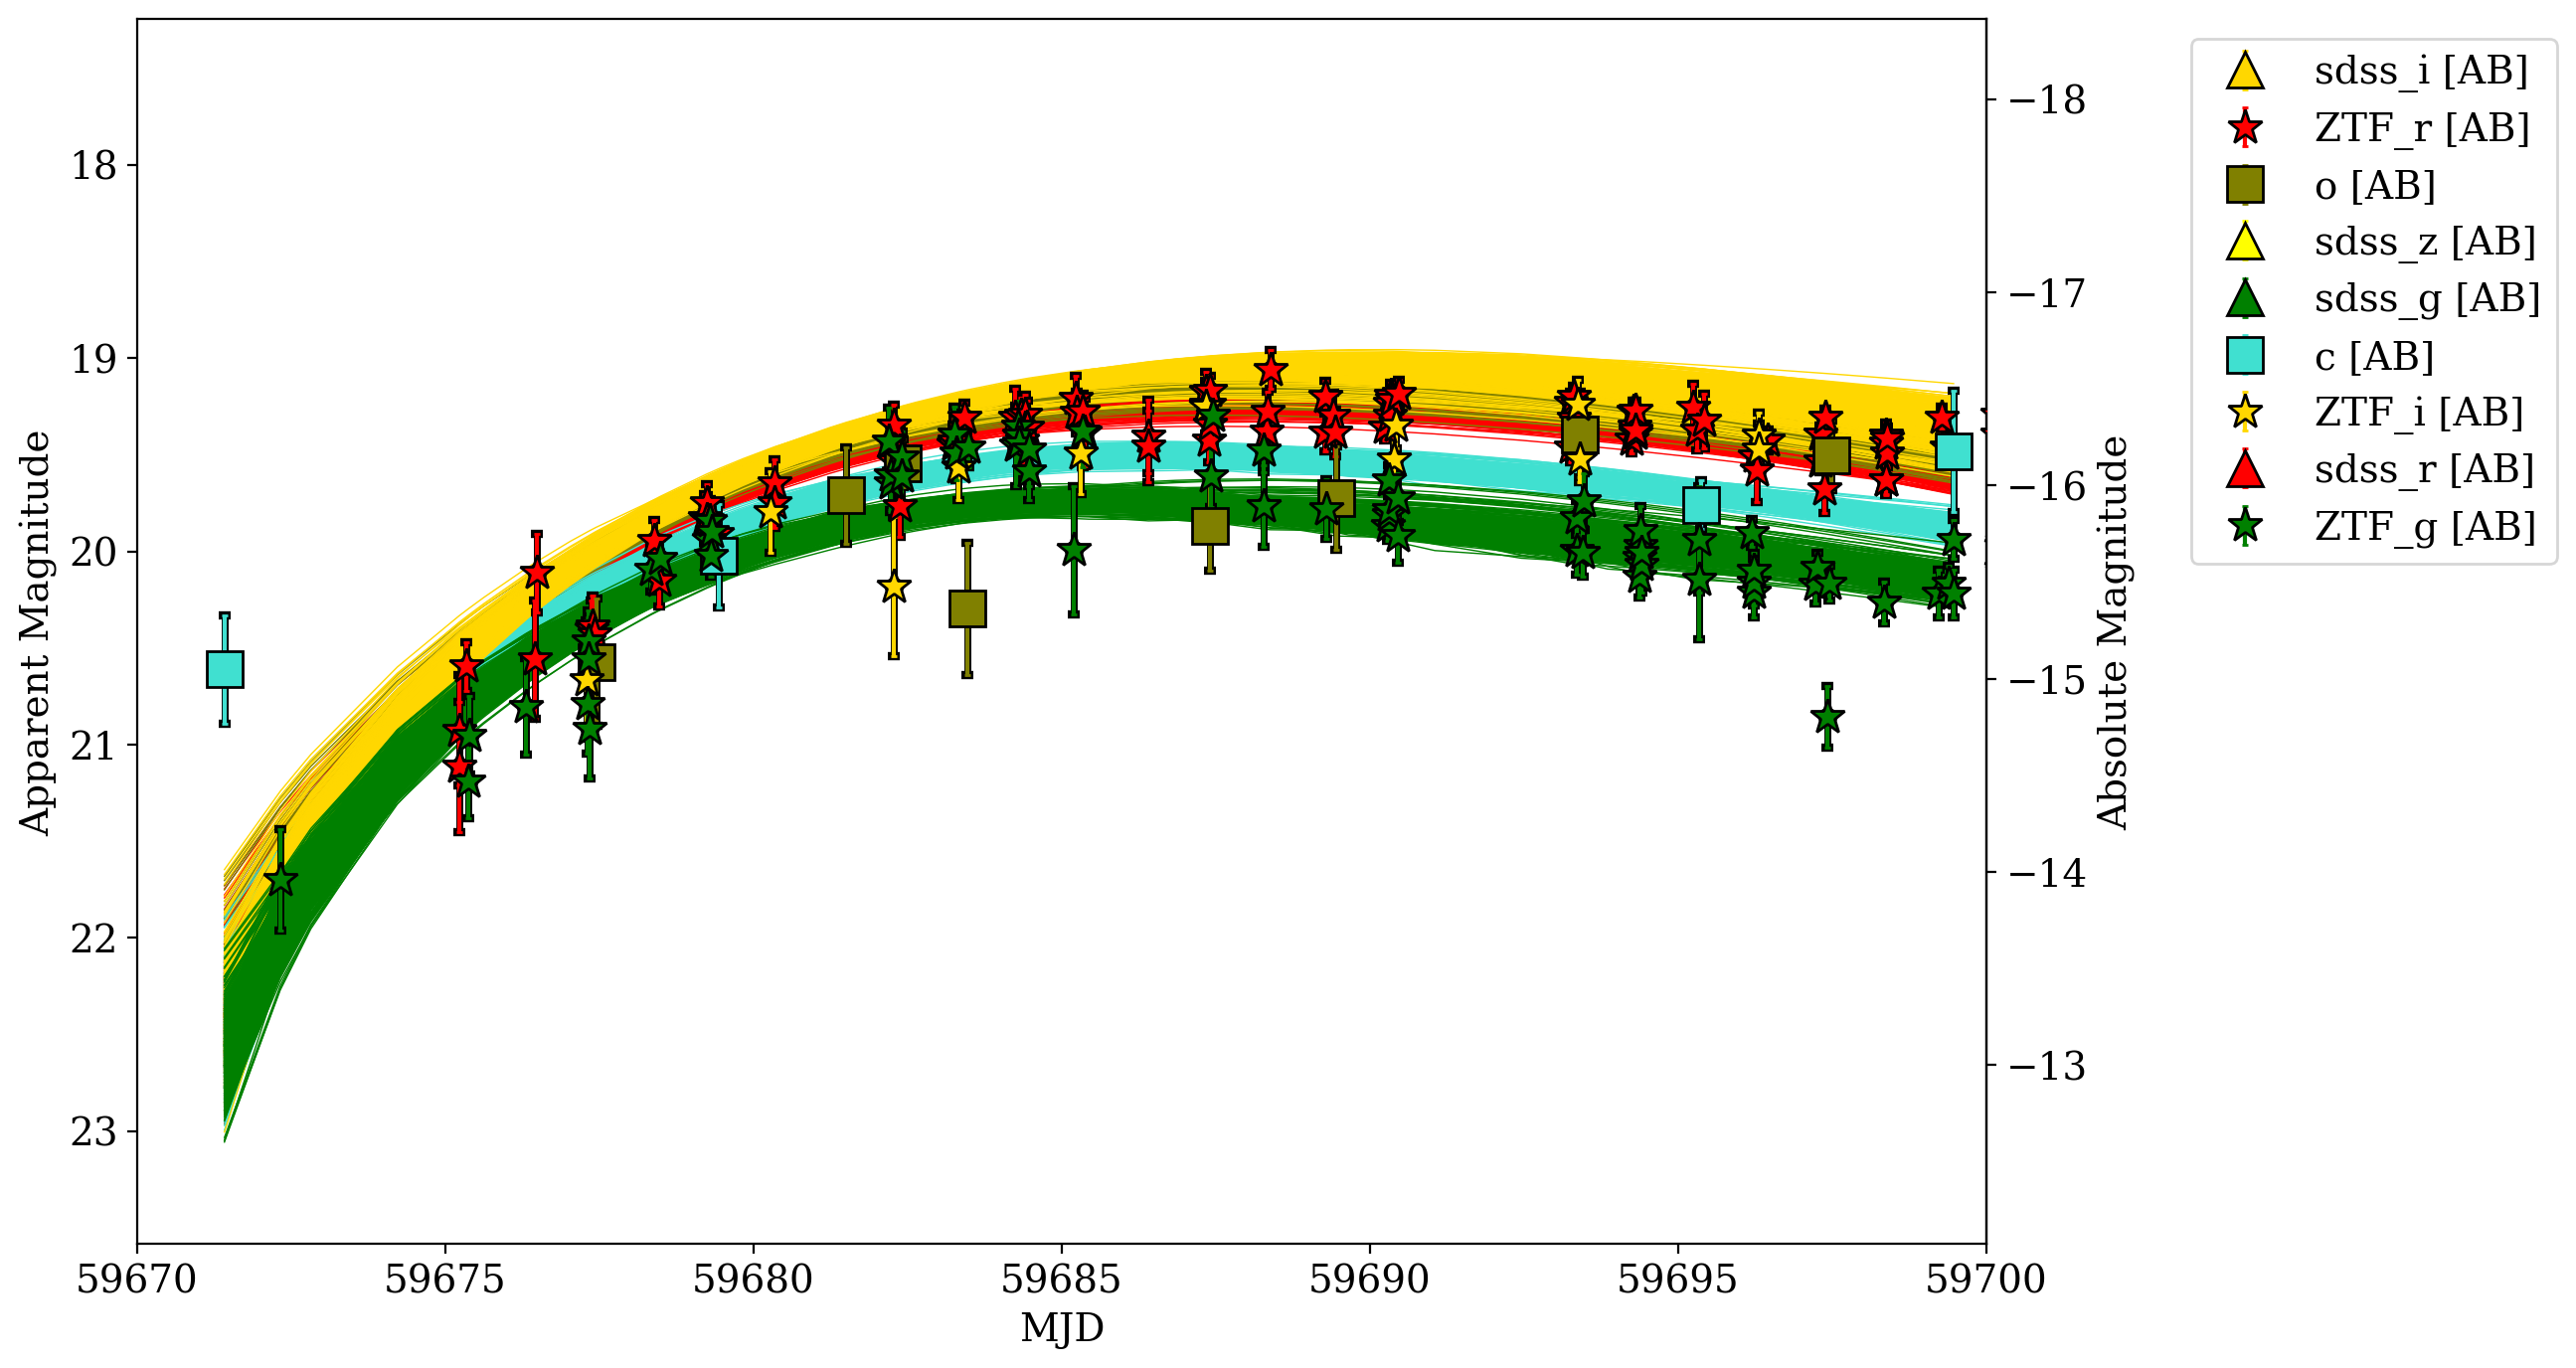

In [5]:
# Uncomment line below to only plot from the specified instruments.
# inst_exclusive_list = ['UVOT']

H0 = 73.04       # 2022ApJ...934L...7R
c = 299792.458   # km/s
d = redshift * c / H0 * 1e6   #pc

def apptoabs(x):
    return x - 5*np.log10(d/10)

def abstoapp(x):
    return x + 5*np.log10(d/10)

fig, ax = plt.subplots(figsize=(12,8))
plt.gca().invert_yaxis()
plt.gca().set_xlabel('MJD')
plt.gca().set_ylabel('Apparent Magnitude')
secax = ax.secondary_yaxis('right', functions = (apptoabs, abstoapp))
secax.set_ylabel('Absolute Magnitude')

used_bands = []
color_band = []

filt_swap     = {'M2':'uvot_uvm2',
                 'W1':'uvot_uvw1',
                 'U':'uvot_u',
                 'B':'uvob_b',
                 'c':'c',
                 'V':'uvot_v', 
                 'o':'o',
                 "g'":'sdss_g',
                 'g':'ZTF_g',
                 "r'":'sdss_r',
                 'r':'ZTF_r',
                 "i'":'sdss_i',
                 'i':'ZTF_i',
                 "z'":'sdss_z'}

color_filt    = {'M2':'purple',
                 'W1':'blueviolet',
                 'U':'blue',
                 'B':'dodgerblue',
                 'c':'turquoise',
                 'V':'turquoise', 
                 'o':'olive',
                 "g'":'green',
                 'g':'green',
                 "r'":'red',
                 'r':'red',
                 "i'":'gold',
                 'i':'gold',
                 "z'":'yellow'}

marker_inst =   {'M2':'o',
                 'W1':'o',
                 'U':'o',
                 'B':'o',
                 'V':'o', 
                 'c':'s',
                 'o':'s',
                 "g'":'^',
                 "r'":'^',
                 "i'":'^',
                 "z'":'^',
                 'g':'*',
                 'r':'*',
                 'i':'*'}         
for full_band in tqdm_notebook(band_list, desc='Photo', leave=False):
    (band, inst, tele, syst, bset) = full_band
    color_band.append(band)
    try:
        inst_exclusive_list
    except:
        pass
    else:
        if inst not in inst_exclusive_list:
            continue
    extra_nice = ', '.join(list(filter(None, OrderedDict.fromkeys((inst, syst, bset)).keys())))
    nice_name = band + ((' [' + extra_nice + ']') if extra_nice else '')
    
    realizations = [[] for x in range(len(model['realizations']))]
    for ph in photo:
        #print(ph)
        rn = ph.get('realization', None)
        si = ph.get('simulated', False)
        if rn and not si:
            if tuple(ph.get(y, '') for y in band_attr) == full_band:
                realizations[int(rn) - 1].append((
                    float(ph['time']), float(ph['magnitude']), [
                        float(ph.get('e_lower_magnitude', ph.get('e_magnitude', 0.0))),
                        float(ph.get('e_upper_magnitude', ph.get('e_magnitude', 0.0)))],
                ph.get('upperlimit')))
    numrz = np.sum([1 for x in realizations if len(x)])
    for rz in realizations:
        if not len(rz):
            continue
        xs, ys, vs, us = zip(*rz)
        label = '' if full_band in used_bands or full_band in real_band_list else nice_name
        if max(vs) == 0.0:
            plt.plot(xs, ys, color=color_filt[band], marker=marker_inst[band], 
                             label=label, linewidth=0.5)
        else:
            xs = np.array(xs)
            ymi = np.array(ys) - np.array([np.inf if u else v[0] for v, u in zip(vs, us)])
            yma = np.array(ys) + np.array([v[1] for v in vs])
            #plt.fill_between(xs, ymi, yma, color=color_filt[band], edgecolor=None,
            #                 label=label, alpha=0.5/numrz, linewidth=0.0)
            plt.plot(xs, ys, color=color_filt[band], 
                             label=label, alpha=1.0, linewidth=0.5)
        if label:
            used_bands = list(set(used_bands + [full_band]))
    if real_data:
        for s in range(2):
            if s == 0:
                cond = False
                symb = 'o'
            else:
                cond = True
                symb = 'v'
            vec = [(float(x['time']), float(x['magnitude']),
                    0.0 if 'upperlimit' in x else float(x.get('e_lower_magnitude', x.get('e_magnitude', 0.0))),
                    float(x.get('e_upper_magnitude', x.get('e_magnitude', 0.0)))) for x in photo
                   if 'magnitude' in x and ('realization' not in x or 'simulated' in x) and
                   'host' not in x and 'includeshost' not in x and
                   x.get('upperlimit', False) == cond and
                   tuple(x.get(y, '') for y in band_attr) == full_band]
            if not len(vec):
                continue
            xs, ys, yls, yus = zip(*vec)
            label = nice_name if full_band not in used_bands else ''
            plt.errorbar(xs, ys, yerr=(yus, yls), color=color_filt[band], fmt=symb, marker=marker_inst[band],
                         label=filt_swap[band]+" ["+extra_nice+"]",
                         markeredgecolor='black', markeredgewidth=1, capsize=1,
                         elinewidth=1.5, capthick=2, zorder=10, markersize = 13)
            plt.errorbar(xs, ys, yerr=(yus, yls), color='k', fmt=symb, capsize=2,
                         elinewidth=2.5, capthick=3, zorder=5)
            plt.xlim(59670, 59700)    # shows first peak
            #plt.xlim(59690, 59800)     # shows second peak
            if label:
                used_bands = list(set(used_bands + [full_band]))
'''                
plt.plot(59709*np.ones(10), np.linspace(22, 22.5, 10), 'k')
plt.plot(59713*np.ones(10), np.linspace(22, 22.5, 10), 'k')
plt.plot(59718*np.ones(10), np.linspace(22, 22.5, 10), 'k')
plt.plot(59719*np.ones(10), np.linspace(22, 22.5, 10), 'k')
plt.plot(59722*np.ones(10), np.linspace(22, 22.5, 10), 'k')
plt.plot(59734*np.ones(10), np.linspace(22, 22.5, 10), 'k')
plt.plot(59738*np.ones(10), np.linspace(22, 22.5, 10), 'k')
plt.plot(59739*np.ones(10), np.linspace(22, 22.5, 10), 'k')
'''
plt.margins(0.02, 0.1)
plt.legend(loc='upper left', bbox_to_anchor = (1.1,1))
plt.show()
fig.savefig('../products/lc.pdf')

### Then, plot observations reported as count rates (e.g. X-ray observations).

### If MOSFiT was run with the `-c` flag, this cell will plot the parameter values (with ranges normalized to unity) over the full chain.

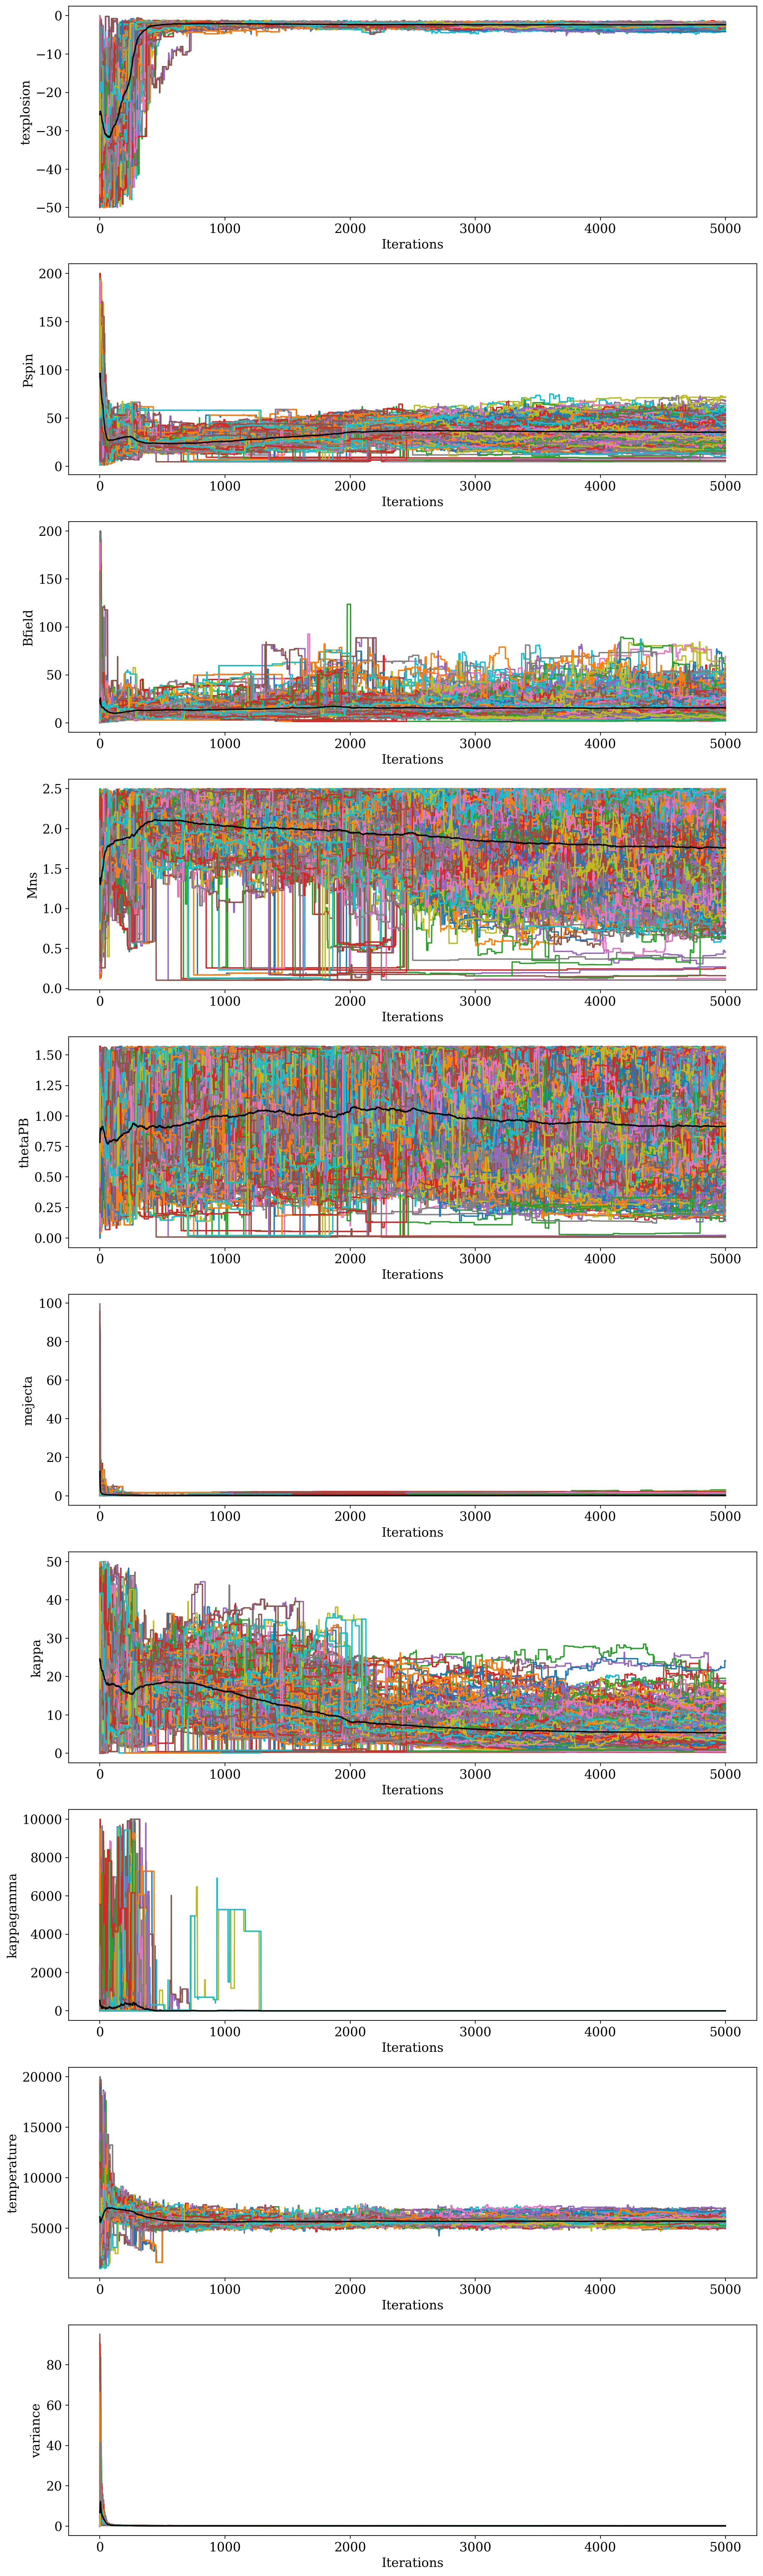

In [3]:
with open('../products/chain.json', 'r', encoding = 'utf-8') as f:
    all_chain = np.array(json.load(f))
    all_chain[0] = np.array(all_chain[0])
    for i in range(len(all_chain[0])) :
        all_chain[0][i] = np.array(all_chain[0][i])
        for j in range(len(all_chain[0][i])) :
            all_chain[0][i][j] = np.array(all_chain[0][i][j])
nparam = len(all_chain[0][0,0,:]);
fig = plt.figure(figsize=(12, nparam * 4));
for pi, param in enumerate(range(nparam)):
    if(all_chain[1][pi] == "lumdist"):
        continue
    my_chain = all_chain[0][:, :, param]
    ax = fig.add_subplot(int(nparam), 1, pi + 1);
    ax.plot(my_chain.T);
    ax.plot(np.mean(my_chain, axis=0), color='k');
    ax.set_xlabel("Iterations")
    ax.set_ylabel(all_chain[1][pi])
plt.tight_layout()

### Lastly, this cell produces a corner plot of all the parameters.

(500, 10)


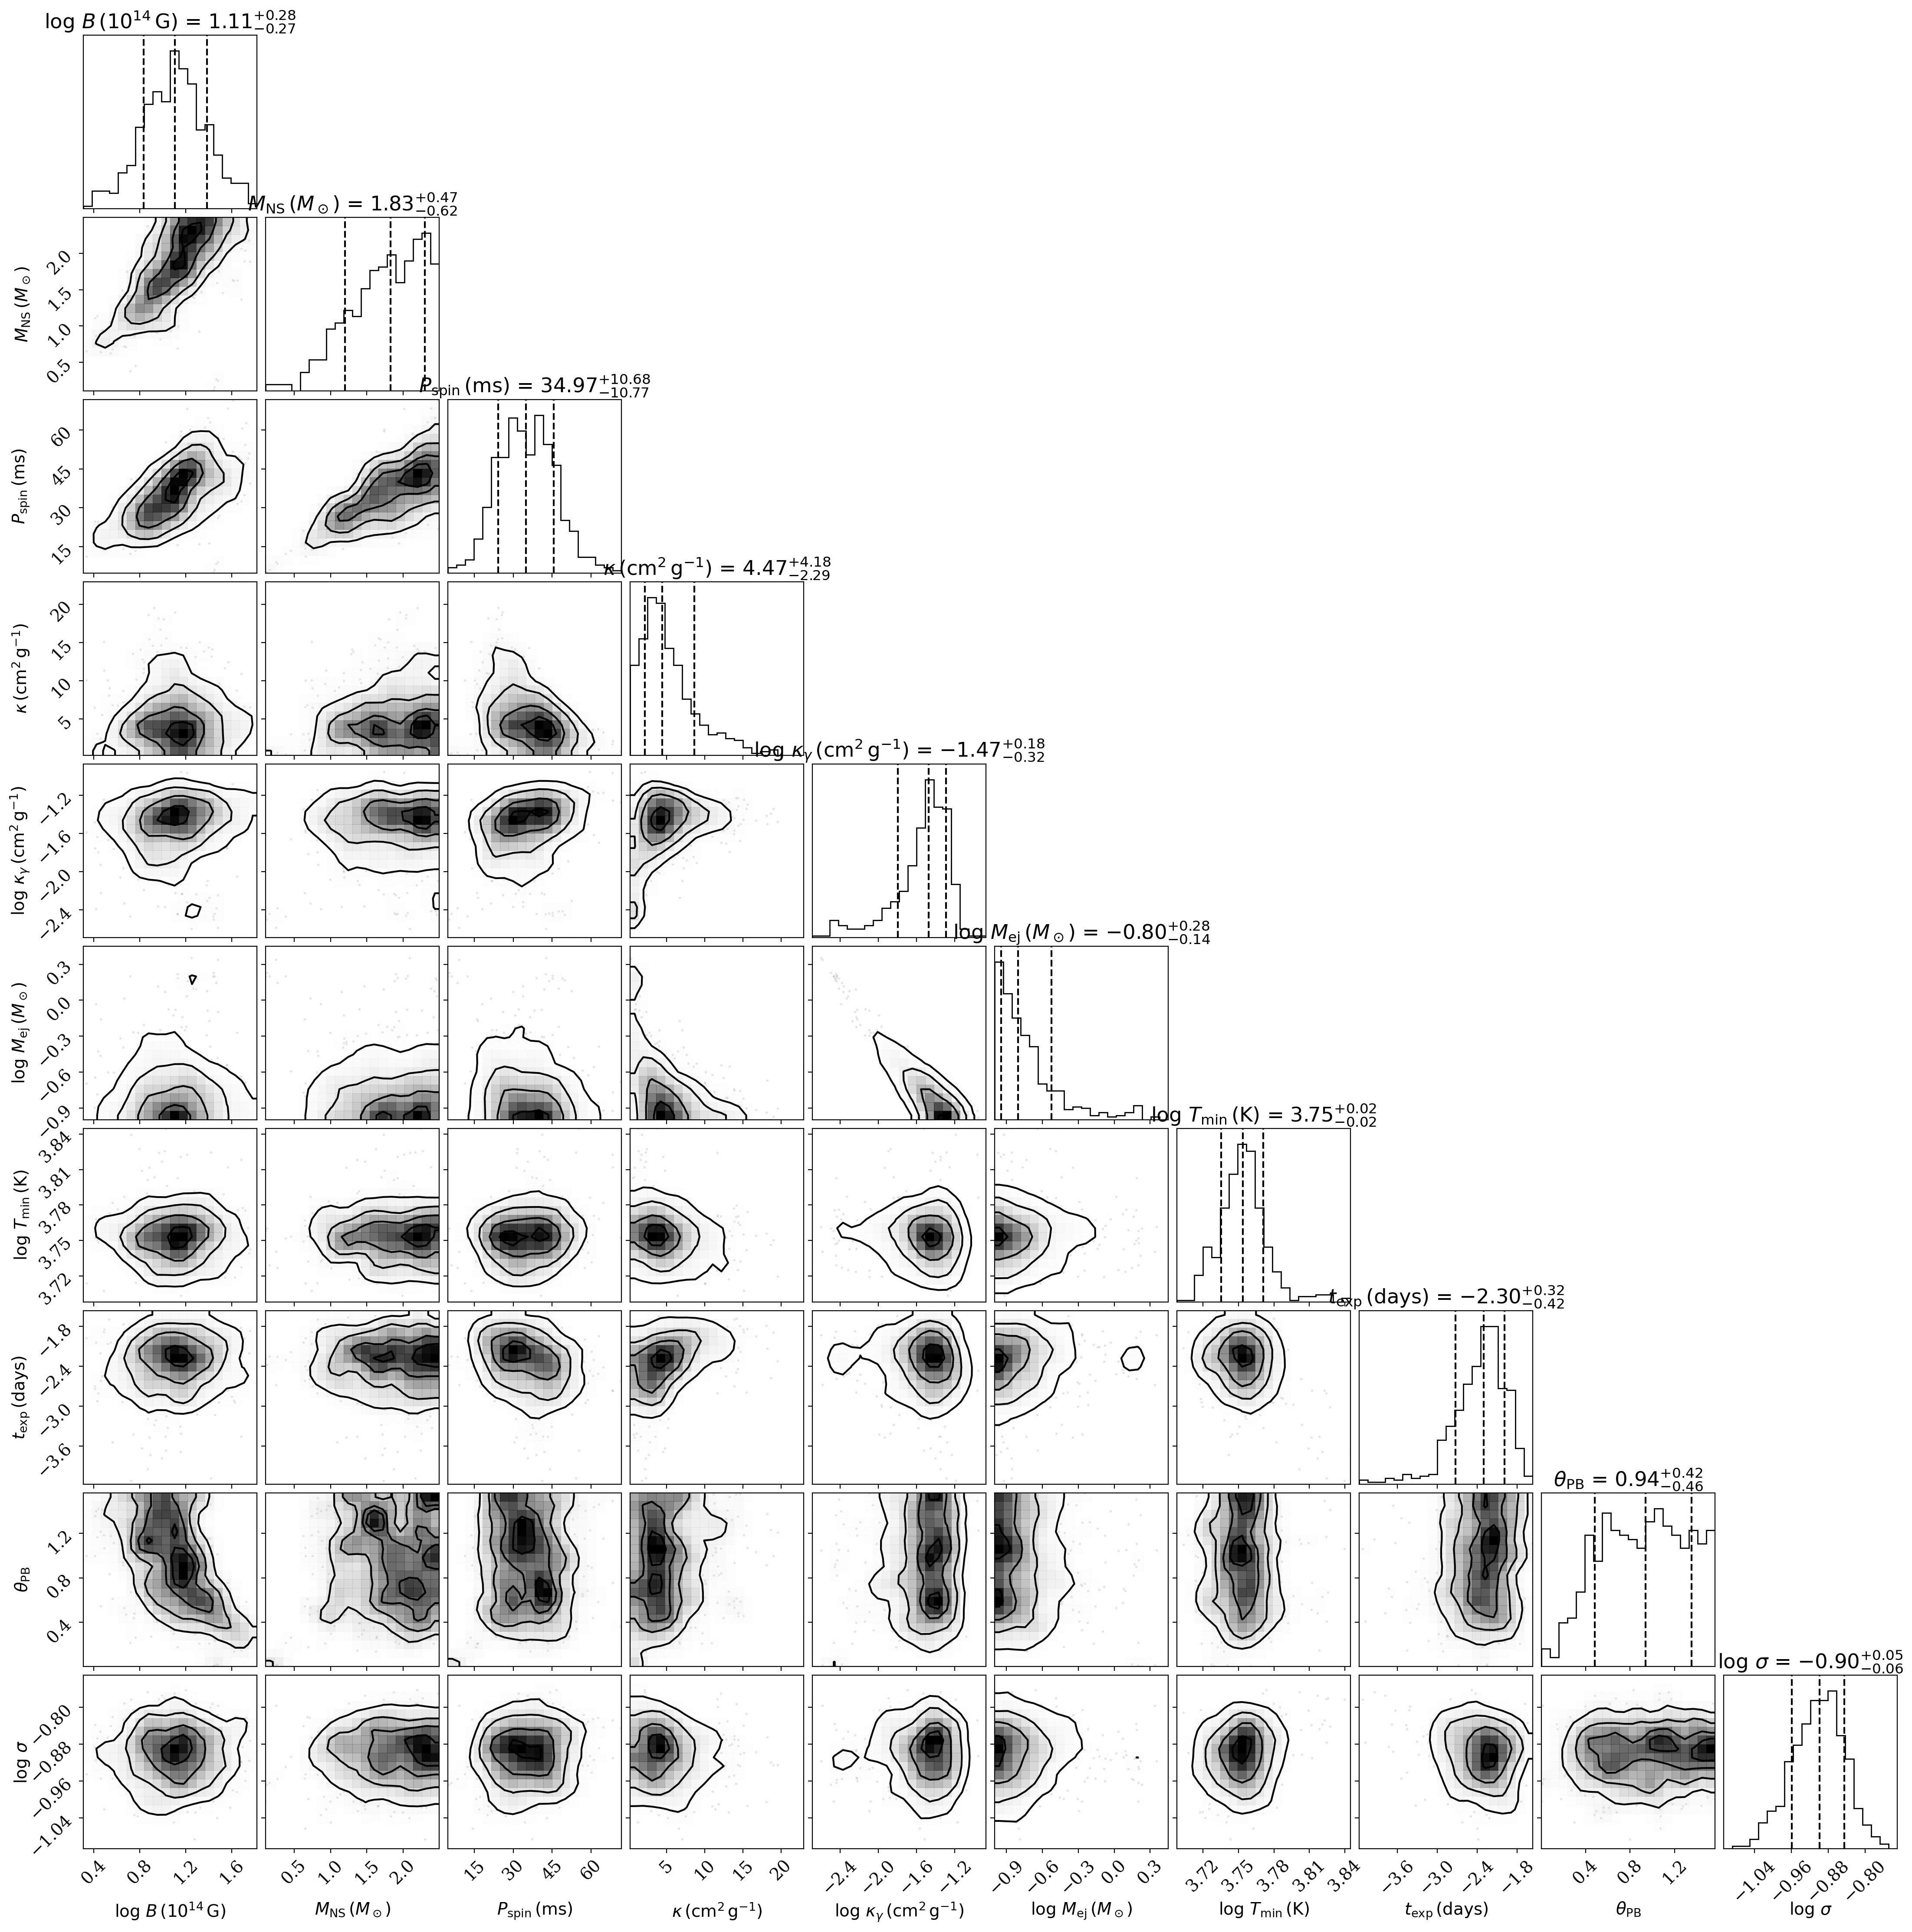

In [4]:
import logging
logging.disable(logging.WARNING)

# Construct walker arrays for corner
corner_input = []
pars = [x for x in model['setup'] if model['setup'][x].get('kind') == 'parameter' and
        'min_value' in model['setup'][x] and 'max_value' in model['setup'][x]]
weights = []
for realization in model['realizations']:
    par_vals = realization['parameters']
    if 'weight' in realization:
        weights.append(float(realization['weight']))
    var_names = ['$' + ('\\log\\, ' if par_vals[x].get('log') else '') +
                 par_vals[x]['latex'] + '$' for x in par_vals if x in pars and 'fraction' in par_vals[x] and par_vals[x]['latex']!='d_{L}']
    corner_input.append([np.log10(par_vals[x]['value']) if
                         par_vals[x].get('log') else par_vals[x]['value'] for x in par_vals
                         if x in pars and 'fraction' in par_vals[x] and par_vals[x]['latex']!='d_{L}'])
weights = weights if len(weights) else None
ranges = [0.999 for x in range(len(corner_input[0]))]
corner_input = np.array(corner_input)
print(corner_input.shape)

cfig = corner.corner(corner_input, labels=var_names, quantiles=[0.16, 0.5, 0.84],
                     show_titles=True, weights=weights, range=ranges, contour_kwargs={'antialiased': True}, smooth = 1.0)
cfig.savefig('../products/corner.pdf')

### The above cells are a demonstration of visualizations of MOSFiT outputs and are not intended to show the full scope of possible outputs, the user is encouraged to experiment with their own notebooks for their projects!

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

def plot_sine_wave(amplitude, frequency):
    x = np.linspace(0, 2 * np.pi, 1000)
    y = amplitude * np.sin(frequency * x)
    
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, label=f'Amplitude: {amplitude}, Frequency: {frequency}')
    plt.ylim(-10, 10)
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Simple slider function for Gene")
    plt.grid(True)
    plt.show()

#plot_sine_wave(10.0, 5.0)
interact(plot_sine_wave, amplitude=(1.0, 10.0, 0.5), frequency=(0.5, 5.0, 0.1))

interactive(children=(FloatSlider(value=5.5, description='amplitude', max=10.0, min=1.0, step=0.5), FloatSlide…

<function __main__.plot_sine_wave(amplitude, frequency)>

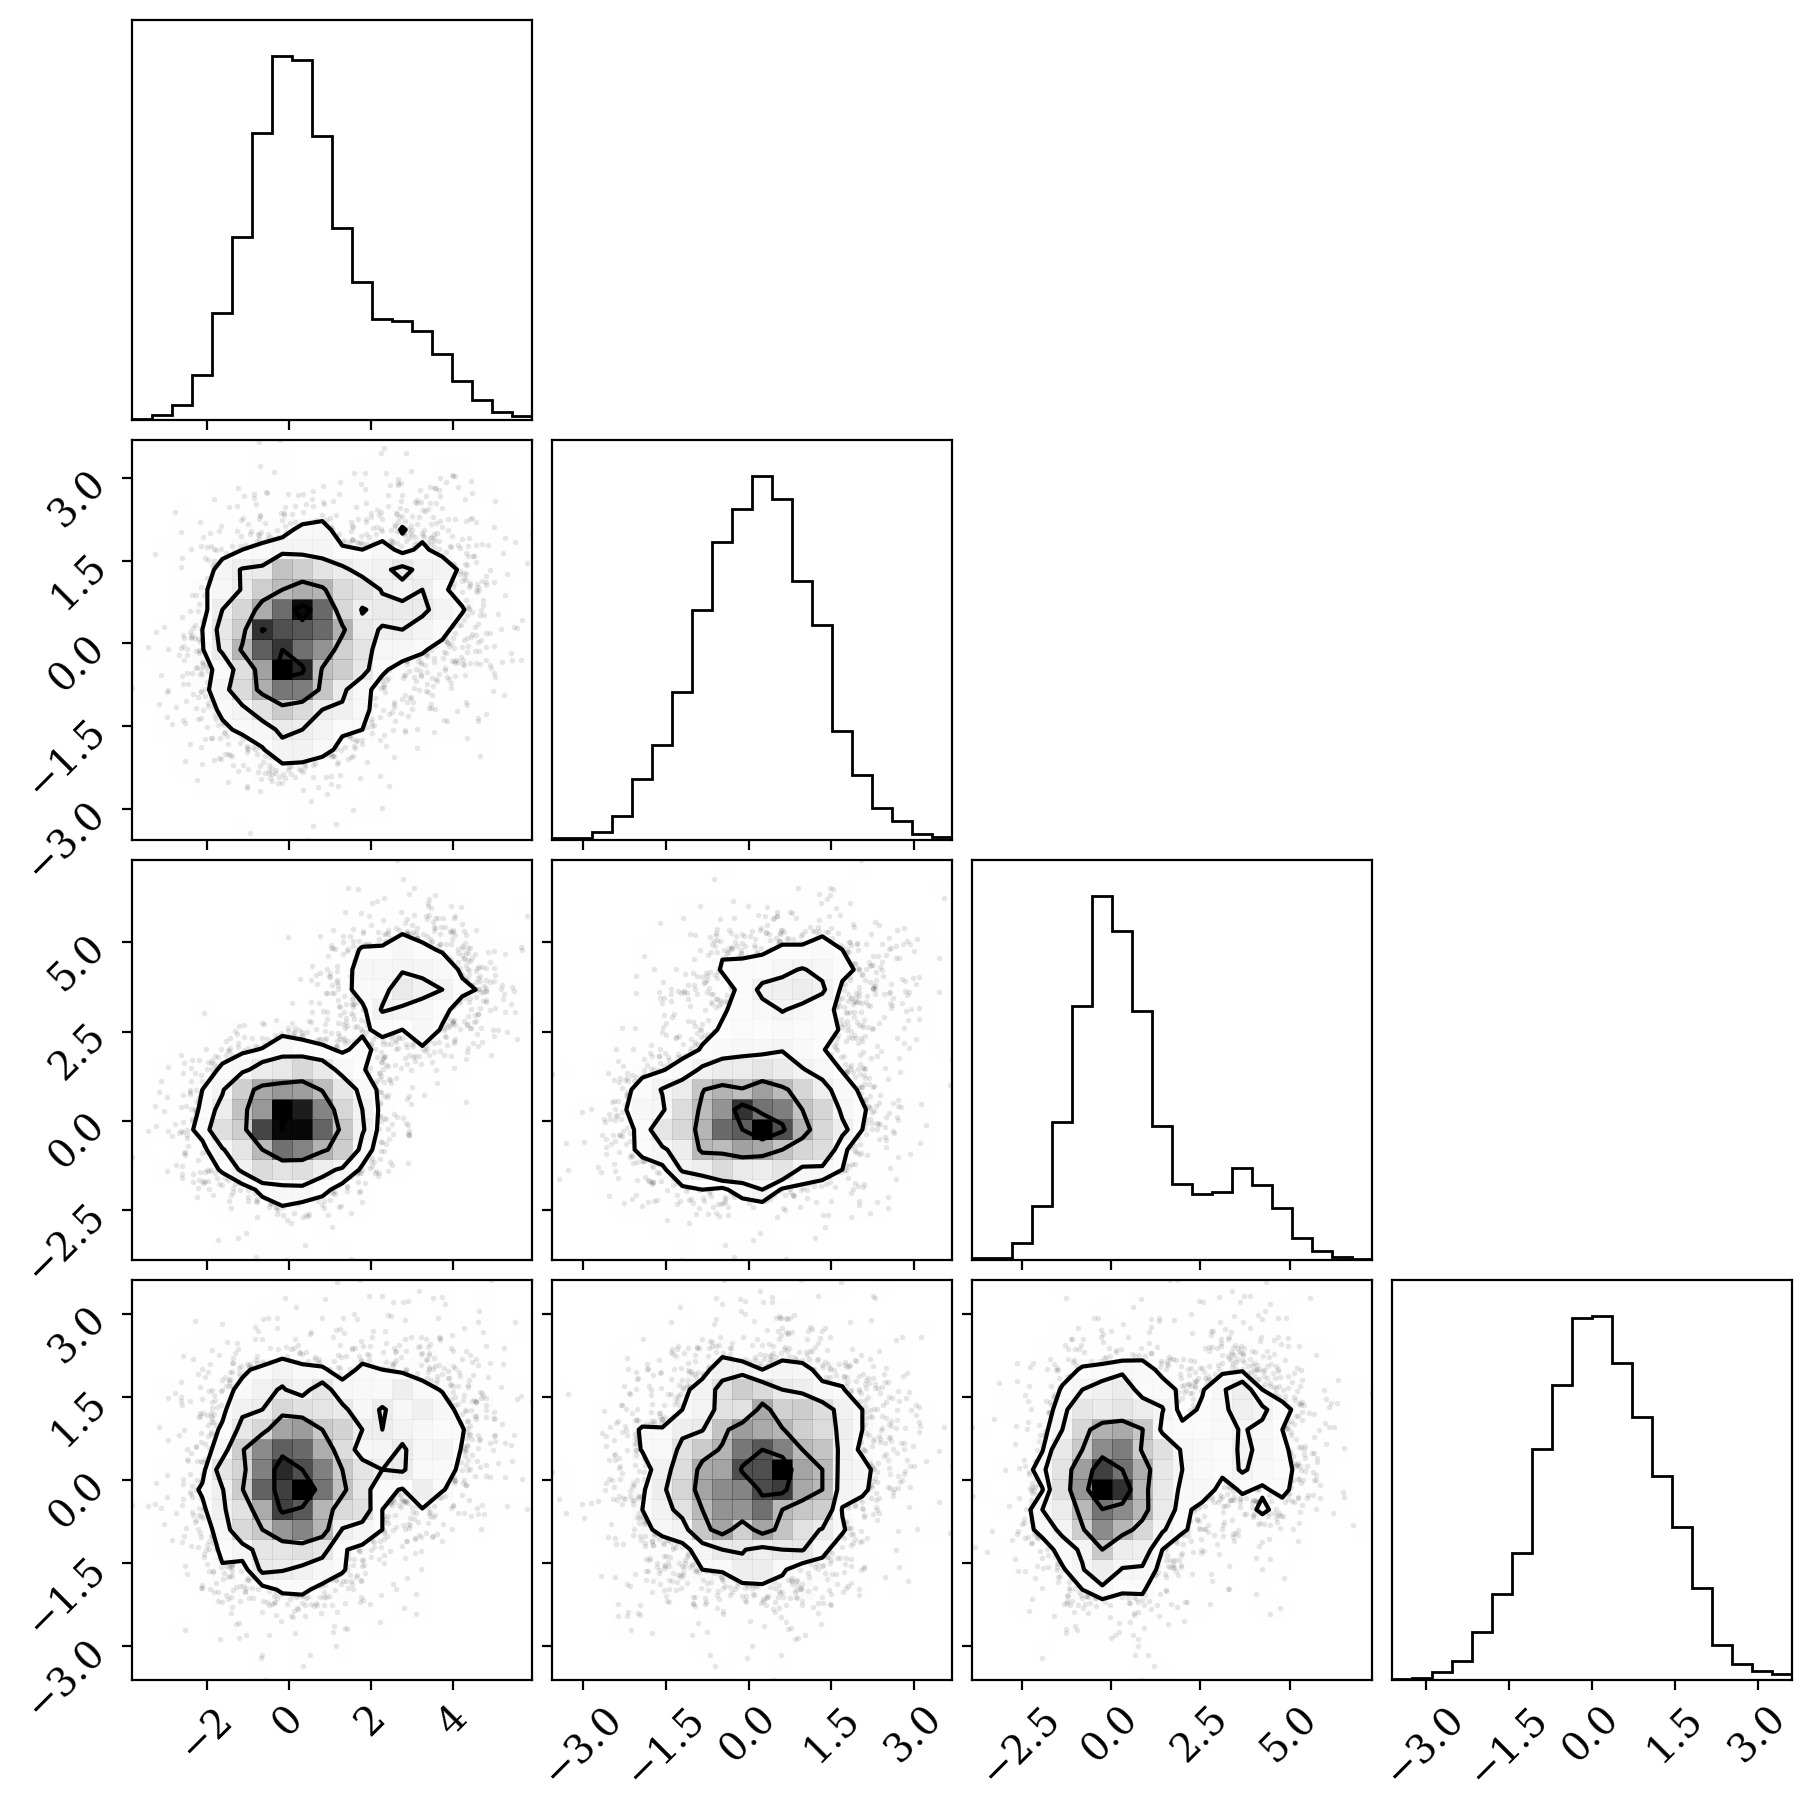

In [10]:
import corner
import numpy as np

ndim, nsamples = 4, 5000
np.random.seed(1234)
data1 = np.random.randn(ndim * 4 * nsamples // 5).reshape(
    [4 * nsamples // 5, ndim]
)
mean = 4 * np.random.rand(ndim)
data2 = mean[None, :] + np.random.randn(ndim * nsamples // 5).reshape(
    [nsamples // 5, ndim]
)
samples = np.vstack([data1, data2])

figure = corner.corner(samples)